# Boundary layer problem: RBF vs. Matern

Given the problem

$$ \epsilon u'' + u' = -e^{-x} \quad\text{ for } x \in (0,1)$$

$$ u(0)=0, u(1)=1$$


where $\epsilon = 0.01$.

**Goal**: Compare the kernel collaction method solution using RBF vs. Matern 5/2. 

## Import libraries

In [14]:
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import jax.numpy as jnp
from importlib import reload

import KernelTools
reload(KernelTools)
from KernelTools import *

from Kernels import *

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm.auto import tqdm

from jax.scipy.linalg import solve

In [109]:
from jax import custom_jvp


@custom_jvp
def two_norm(x):
  return jnp.sqrt(jnp.sum(x**2))

def smoothed_two_norm(x,eps = 1e-16):
  return jnp.sqrt(jnp.sum(x**2)+eps**2) - eps

@two_norm.defjvp
def two_norm_jvp(primals, tangents):
  x, = primals
  x_dot, = tangents
  ans = two_norm(x)
  ans_dot = jnp.dot(x/smoothed_two_norm(x),x_dot)
  return ans, jnp.where(ans>=1e-8,ans_dot,0.)


In [ ]:
import sympy as sym
from sympy import factorial
from sympy.series.series import series

def setup_matern(p):
    exp_multiplier = -sym.sqrt(2 * p + 1)
    coefficients = [
        (factorial(p)/factorial(2*p)) * (factorial(p + i) / (factorial(i) * factorial(p - i)))
        * (sym.sqrt(8 * p + 4))**(p - i) 
        for i in range(p + 1)]
    powers = list(range(p,-1,-1))

    jax_coefficients = jnp.array(list(map(float,coefficients)))
    jax_powers = jnp.array(powers)
    jax_exp_multiplier = float(exp_multiplier)

    d = sym.symbols('d')
    matern = sum([c * (d**power) for c,power in zip(coefficients,powers)])*sym.exp(exp_multiplier * d)

    def matern_p_factory(rho):
        def matern_func(x,y):
            scaled_diff = (x-y)/rho
            d = two_norm(scaled_diff)
            matern_eval= jnp.sum(jax_coefficients*jnp.power(d,jax_powers))*jnp.exp(jax_exp_multiplier * d)
            return matern_eval
        
        return matern_func
    return matern_p_factory


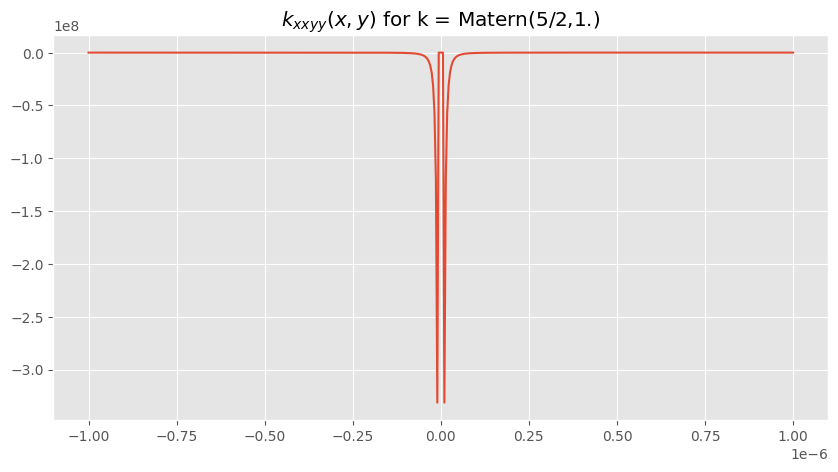

In [112]:
k = setup_matern(2)(1.)
extent = 1e-6
grid = jnp.linspace(-extent,extent,500)
result = jax.vmap(diff2_k(diff2_k(k,0),1),in_axes = (None,0))(0.,grid)
plt.figure(figsize=(10,5))
plt.plot(grid,result)
plt.title("$k_{xxyy}(x,y)$ for k = Matern(5/2,1.)")
plt.show()

### Utils

In [17]:
def solve_blp(kernel,nugget, epsilon):
    k = kernel
    ## Grid

    # Full points
    x_grid = np.linspace(0,1,501)
    # Interior points
    interior_x = x_grid[1:-1]
    # Boundary points
    boundary_x = np.hstack([x_grid[:1],x_grid[-1:]])

    ## Build K(phi,phi)

    eps = epsilon

    def L_op(k,index):
        def op_result(x,y):
            inputs_arr = jnp.array([x,y])
            return eps * diff2_k(k,index)(x,y) + diff_k(k,index)(x,y)
        return op_result

    K_full = np.block(
        [
            [
                get_kernel_block_ops(k,[eval_k],[eval_k])(boundary_x,boundary_x),
                get_kernel_block_ops(k,[eval_k],[L_op])(boundary_x,interior_x)
            
            ],
            [
                get_kernel_block_ops(k,[L_op],[eval_k])(interior_x,boundary_x),
                get_kernel_block_ops(k,[L_op],[L_op])(interior_x,interior_x)
            ]
        ]
                    )
    ## Find the interpolant

    bc_vals = np.array([0,1])

    def rhs_func(x):
        return -1*np.exp(-1*x)
    rhs = np.hstack([bc_vals,rhs_func(interior_x)])

    nugget = nugget*jnp.diag(np.hstack([np.zeros(2),jnp.diag(K_full)[2:]]))
    coeffs = solve(K_full+nugget,rhs,assume_a = 'pos')

    fine_grid = np.linspace(0,1,501)
    K_interp = np.block([get_kernel_block_ops(k,[eval_k],[eval_k])(fine_grid,boundary_x),
            get_kernel_block_ops(k,[eval_k],[L_op])(fine_grid,interior_x)])
    sol_vals = K_interp@coeffs
    residual = (rhs-K_full@coeffs)

    ## True u
    def u_true(x,eps):
        coeff = np.exp(-1-x)/(-1+ np.exp(1/eps))/(-1+eps) 
        part1 = np.exp(1)-np.exp(1+1/eps)-np.exp(1+x)+np.exp(1/eps + x) -np.exp((1+x*(-1+eps))/(eps))
        part2 = -np.exp(1+ 1/eps + x - x/eps)*(-2+eps) + np.exp(1 + 1/eps + x)*(-1+eps)
        return coeff*(part1 + part2)

    # Plot the results

    plt.figure(figsize=(10,6.5))
    #plt.suptitle("Solving BLP with {} kernel and length scale {}\n".format(kernel, length_scale))
    
    plt.subplot(2,2,1)
    plt.title(r'$u$ vs. $\hat u$',fontsize='small')
    plt.plot(fine_grid,u_true(fine_grid,eps),c='black', label = 'True')
    plt.plot(fine_grid,sol_vals,c='red',linestyle= 'dashed', label = 'Numerical')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(r'$P(u)$ vs.$P(\hat u)$',fontsize='small')
    plt.plot(interior_x, rhs[2:],c='black', label = 'True')
    plt.plot(interior_x, (K_full@coeffs)[2:],c='red',linestyle= 'dashed', label = 'Numerical')
    plt.legend()
    
    plt.subplot(2,2,3)
    plt.title(r'Solution residual: $|u - \hat u|$',fontsize='small')
    plt.plot(fine_grid,jnp.abs(sol_vals-u_true(fine_grid,eps)))
    plt.yscale('log')

    plt.subplot(2,2,4)
    plt.title(r'Equation Residual: $|P(u) - P(\hat u)|$',fontsize='small')
    plt.plot(interior_x,jnp.abs(residual)[2:])
    plt.yscale('log')

    plt.show()
        
        

## Results

### $\epsilon = 0.05$

RBF kernel

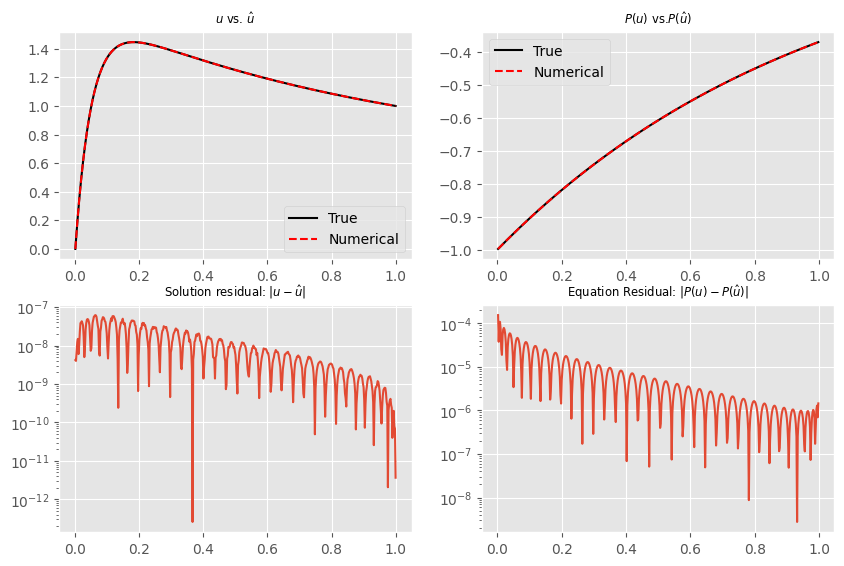

In [18]:
kernel = get_gaussianRBF(0.1)

solve_blp(kernel,nugget = 1e-12, epsilon = 0.05)

Matern 5/2

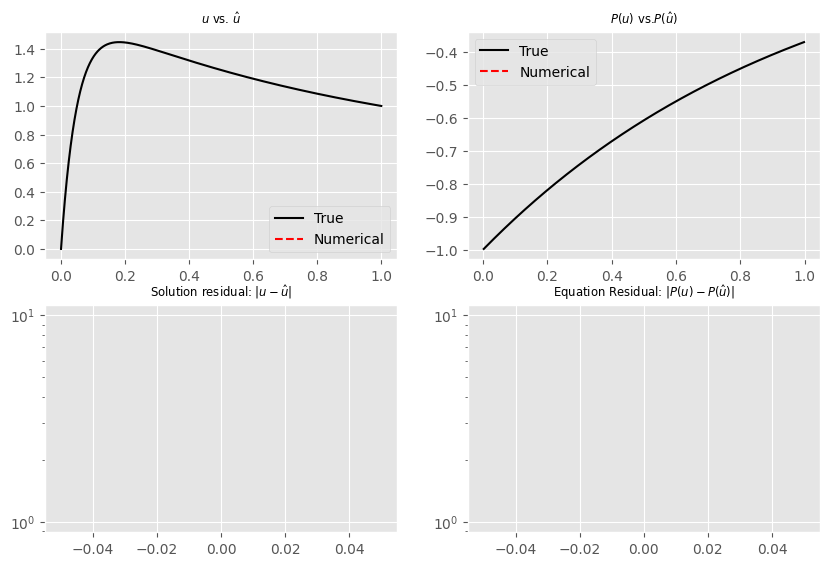

In [19]:
kernel = setup_matern(2)(0.1)
solve_blp(kernel,nugget = 0, epsilon = 0.05)

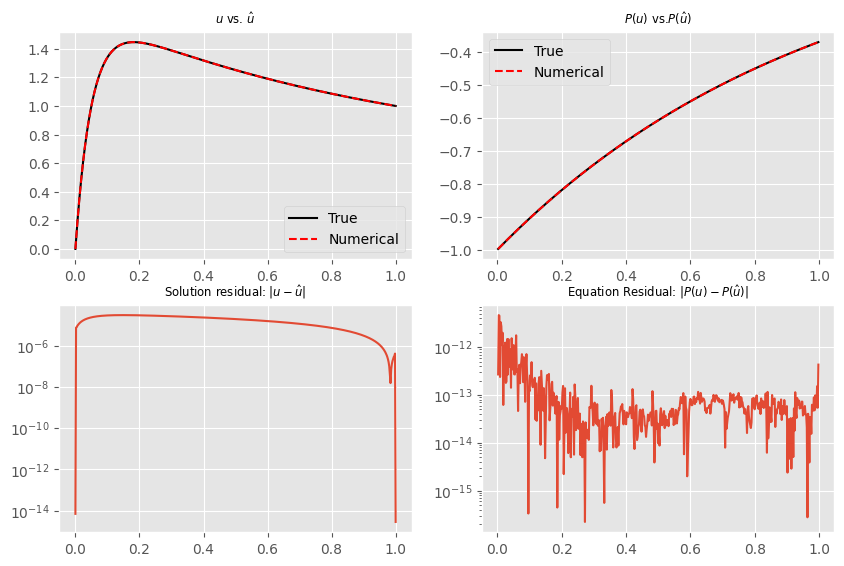

In [31]:
kernel = setup_matern(3)(0.1)
solve_blp(kernel,nugget = 0, epsilon = 0.05)

Matern 11/2

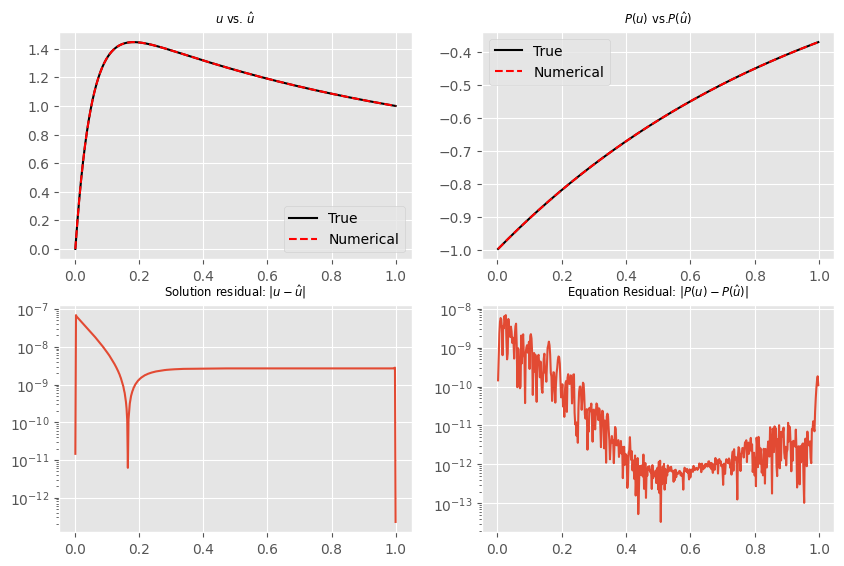

In [17]:
kernel = setup_matern(5)(0.1)

solve_blp(kernel,nugget = 0, epsilon = 0.05)

### $\epsilon = 0.01$

RBF

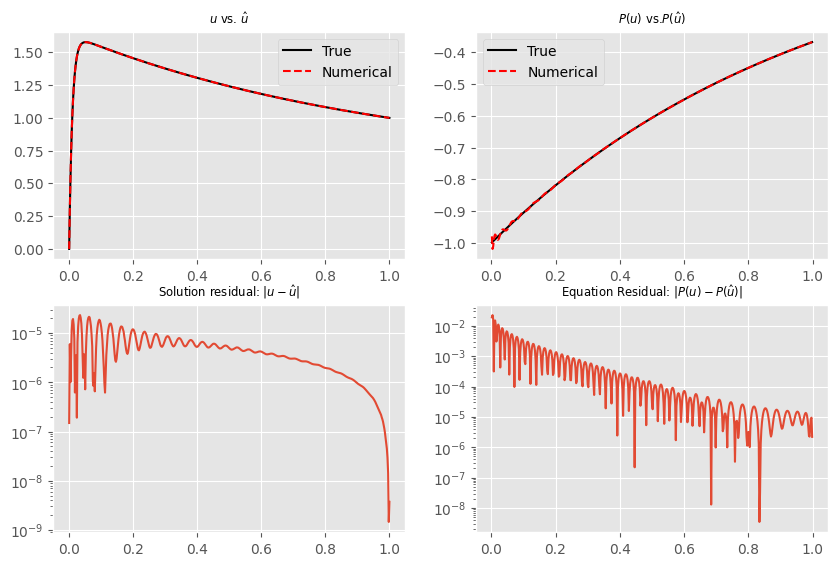

In [30]:
kernel = get_gaussianRBF(0.05)

solve_blp(kernel,nugget = 1e-12, epsilon = 0.01)

Matern 5/2

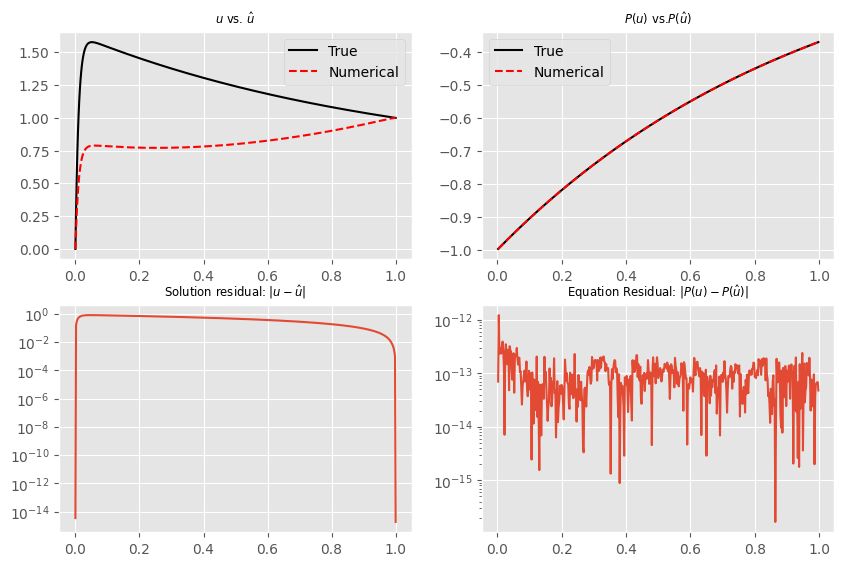

In [20]:
kernel = setup_matern(2)(0.05)
solve_blp(kernel, nugget = 0, epsilon = 0.01)

Matern 11/2

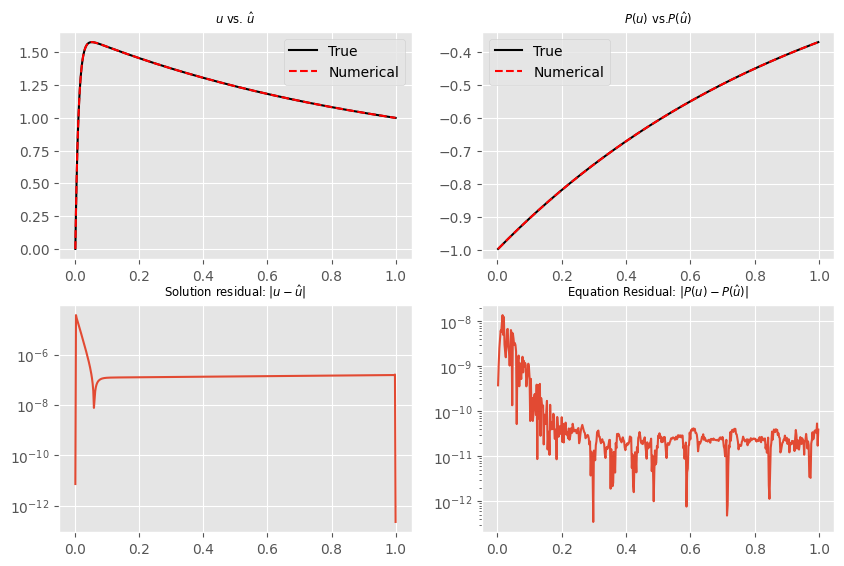

In [22]:
kernel = setup_matern(5)(0.05)

solve_blp(kernel, nugget = 0, epsilon = 0.01)

- Plot at a finer mesh grid to explain this behaviour.

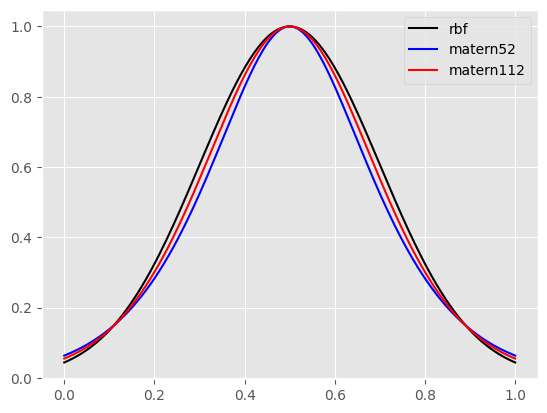

In [23]:
xtest = jnp.linspace(0,1,200)
k_rbf = vectorize_kfunc(get_gaussianRBF(.2))
k_mattern5_2 = vectorize_kfunc(get_matern(2,.2))
k_mattern11_2 = vectorize_kfunc(get_matern(5,.2))

plt.plot(xtest,k_rbf(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'black', label = 'rbf')
plt.plot(xtest,k_mattern5_2(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'blue',label = 'matern52')
plt.plot(xtest,k_mattern11_2(xtest.reshape(-1,1),jnp.array([[0.5]])), c = 'red',label = 'matern112')
plt.legend()